<a href="https://colab.research.google.com/github/subs04/AI_final_project/blob/main/2548183_Subarna_Tamang_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regression Analysis of Student Performance Factors  
## UNSDG 4: Quality Education

This project investigates factors affecting student academic performance using regression techniques.  
The goal is to predict students' exam scores and analyze how various academic, social, and personal factors influence educational outcomes, aligning with **United Nations Sustainable Development Goal 4 (Quality Education)**.


## 1. Dataset Description and Understanding

### Dataset Source
- The dataset was created by contributors on **Kaggle** for educational and analytical purposes.
- It was accessed in **2024** as a CSV file and loaded into Google Colab.

### UNSDG Alignment
This dataset aligns with **UNSDG 4: Quality Education**, as it focuses on:
- Student study habits
- Attendance
- Family and social background
- Academic support factors  

These variables help identify patterns that can improve learning outcomes and educational quality.

### Target Variable
- **Exam_Score**: Final exam score of students (continuous numerical value).

### Potential Questions
1. How do study habits affect exam performance?
2. Which factors most strongly influence exam scores?
3. Can student performance be accurately predicted using regression models?

### Dataset Suitability
- The dataset is complete and well-structured.
- Contains both numerical and categorical features.
- Suitable for regression due to a continuous target variable.


#Importing libraries

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

from sklearn.feature_selection import SequentialFeatureSelector

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error



#Loading Dataset

In [34]:
df = pd.read_csv("/content/drive/MyDrive/StudentPerformanceFactors.csv")

print(df.head())
print("Dataset shape:", df.shape)


   Hours_Studied  Attendance Parental_Involvement Access_to_Resources  \
0             23          84                  Low                High   
1             19          64                  Low              Medium   
2             24          98               Medium              Medium   
3             29          89                  Low              Medium   
4             19          92               Medium              Medium   

  Extracurricular_Activities  Sleep_Hours  Previous_Scores Motivation_Level  \
0                         No            7               73              Low   
1                         No            8               59              Low   
2                        Yes            7               91           Medium   
3                        Yes            8               98           Medium   
4                        Yes            6               65           Medium   

  Internet_Access  Tutoring_Sessions Family_Income Teacher_Quality  \
0             Ye

## Dataset Attributes

| Attribute | Description |
|--------|------------|
| Hours_Studied | Average daily study hours |
| Attendance | Attendance percentage |
| Parental_Education | Parents' highest education level |
| Sleep_Hours | Average sleep duration |
| Internet_Access | Availability of internet |
| Tutoring | Access to tutoring support |
| Exam_Score | Final exam score (Target Variable) |


## 2. Exploratory Data Analysis (EDA)

EDA is conducted to understand data distribution, detect patterns, and identify potential issues such as outliers or skewness before model building.


#SUMMARY STATISTICS

In [35]:
df.describe()


,Hours_Studied,Attendance,Sleep_Hours,Previous_Scores,Tutoring_Sessions,Physical_Activity,Exam_Score
count,6607.000000,6607.000000,6607.00000,6607.000000,6607.000000,6607.000000,6607.000000
mean,19.975329,79.977448,7.02906,75.070531,1.493719,2.967610,67.235659
std,5.990594,11.547475,1.46812,14.399784,1.230570,1.031231,3.890456
min,1.000000,60.000000,4.00000,50.000000,0.000000,0.000000,55.000000
25%,16.000000,70.000000,6.00000,63.000000,1.000000,2.000000,65.000000
50%,20.000000,80.000000,7.00000,75.000000,1.000000,3.000000,67.000000
75%,24.000000,90.000000,8.00000,88.000000,2.000000,4.000000,69.000000
max,44.000000,100.000000,10.00000,100.000000,8.000000,6.000000,101.000000


#TARGET DISTRIBUTION

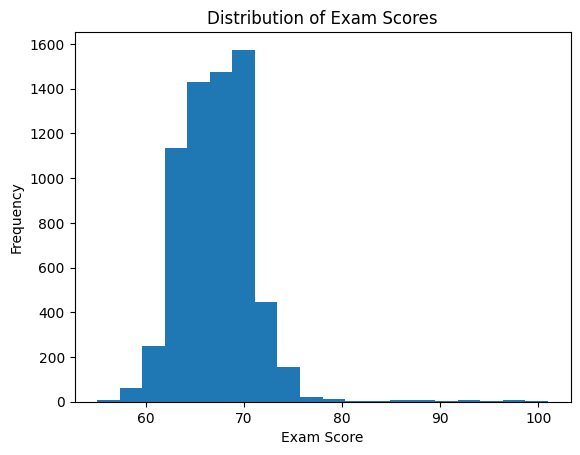

In [36]:
plt.hist(df['Exam_Score'], bins=20)
plt.xlabel("Exam Score")
plt.ylabel("Frequency")
plt.title("Distribution of Exam Scores")
plt.savefig("exam_score_distribution.png")
plt.show()


#INTERPRETATION
The distribution shows that exam scores are approximately normally distributed, indicating suitability for regression modeling.


#FEATURE VS TARGET

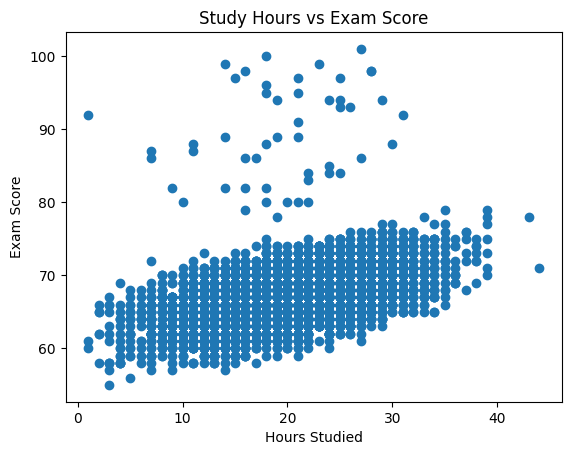

In [37]:
plt.scatter(df['Hours_Studied'], df['Exam_Score'])
plt.xlabel("Hours Studied")
plt.ylabel("Exam Score")
plt.title("Study Hours vs Exam Score")
plt.savefig("study_hours_vs_exam_score.png")
plt.show()


# Boxplot Analysis


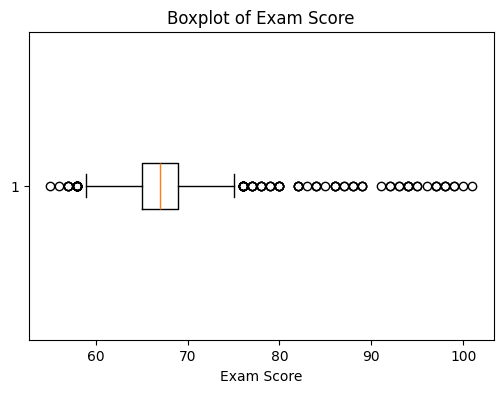

In [38]:
plt.figure(figsize=(6, 4))
plt.boxplot(df['Exam_Score'], vert=False)
plt.xlabel("Exam Score")
plt.title("Boxplot of Exam Score")
plt.savefig("boxplot_exam_score.png")
plt.show()


# Correlation Matrix


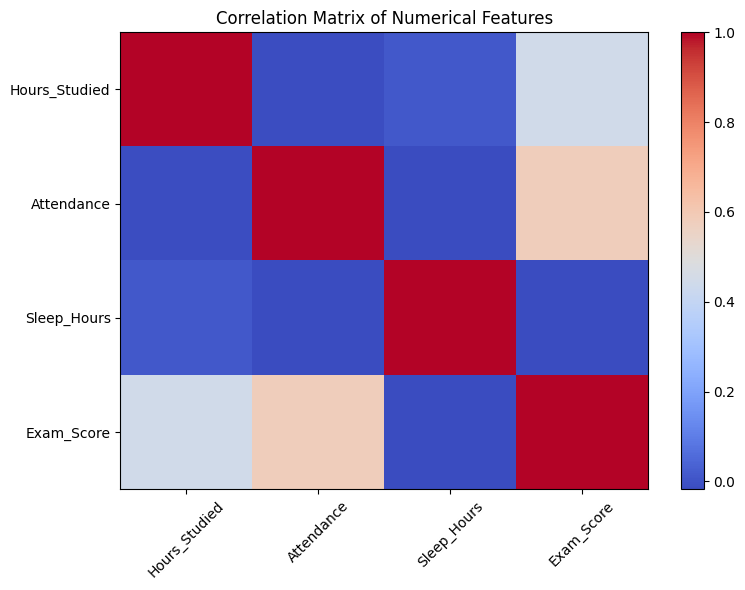

,Hours_Studied,Attendance,Sleep_Hours,Exam_Score
Hours_Studied,1.000000,-0.009908,0.010977,0.445455
Attendance,-0.009908,1.000000,-0.015918,0.581072
Sleep_Hours,0.010977,-0.015918,1.000000,-0.017022
Exam_Score,0.445455,0.581072,-0.017022,1.000000


In [39]:
numerical_cols= ['Hours_Studied', 'Attendance', 'Sleep_Hours', 'Exam_Score']
corr_matrix = df[numerical_cols].corr()

plt.figure(figsize=(8, 6))
plt.imshow(corr_matrix, cmap='coolwarm', aspect='auto')
plt.colorbar()

plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=45)
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)

plt.title("Correlation Matrix of Numerical Features")
plt.tight_layout()
plt.savefig("correlation_matrix.png")
plt.show()

corr_matrix

#EDA INSIGHT
A positive relationship is observed between hours studied and exam scores, suggesting study time significantly impacts performance.


#Define Features (X) and Target (Y)

In [40]:
y = df['Exam_Score']
X = df.drop('Exam_Score', axis=1)


#Handle Categorical & Numerical Features

In [41]:
categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns


#Preprocessing (Encoding + Scaling)

In [42]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first'), categorical_cols)
    ]
)


#Train–Test Split

In [43]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


## 3. Neural Network Model for Regression

A simple Artificial Neural Network (Multi-Layer Perceptron) is used to predict
students’ exam scores.  
This model captures non-linear relationships between features and the target.

### Architecture:
- Input Layer: All encoded features
- Hidden Layer 1: 32 neurons (ReLU)
- Hidden Layer 2: 16 neurons (ReLU)
- Output Layer: 1 neuron (continuous output)

### Loss Function:
- Mean Squared Error (MSE)

### Optimizer:
- Adam


#Neural Network Implementation

In [44]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

X_nn = pd.get_dummies(X, drop_first=True)

X_train_nn, X_test_nn, y_train_nn, y_test_nn = train_test_split(
    X_nn, y, test_size=0.2, random_state=42
)

scaler_nn = StandardScaler()
X_train_nn = scaler_nn.fit_transform(X_train_nn)
X_test_nn = scaler_nn.transform(X_test_nn)

nn_model = Sequential()
nn_model.add(Dense(32, activation='relu', input_shape=(X_train_nn.shape[1],)))
nn_model.add(Dense(16, activation='relu'))
nn_model.add(Dense(1))

nn_model.compile(
    optimizer=Adam(learning_rate=0.01),
    loss='mse'
)

nn_model.fit(
    X_train_nn,
    y_train_nn,
    epochs=50,
    batch_size=32,
    verbose=0
)

y_pred_nn = nn_model.predict(X_test_nn)

print("Neural Network MSE:", mean_squared_error(y_test_nn, y_pred_nn))
nn_mae = mean_absolute_error(y_test_nn, y_pred_nn)
nn_rmse = np.sqrt(mean_squared_error(y_test_nn, y_pred_nn))

print("Neural Network MAE:", nn_mae)
print("Neural Network RMSE:", nn_rmse)
print("Neural Network R2:", r2_score(y_test_nn, y_pred_nn))



/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Neural Network MSE: 5.193480014801025
Neural Network MAE: 1.2432810068130493
Neural Network RMSE: 2.278920800466972
Neural Network R2: 0.6325820684432983


## 3. Primary Machine Learning Models
Two classical regression models are implemented:
1. Linear Regression
2. K-Nearest Neighbors (KNN) Regression


#Linear Regression (Primary Model)

In [45]:
lr = LinearRegression()

from sklearn.pipeline import Pipeline

lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', lr)
])

lr_pipeline.fit(X_train, y_train)

y_pred_lr = lr_pipeline.predict(X_test)

print("Linear Regression MAE:", mean_absolute_error(y_test, y_pred_lr))
print("Linear Regression MSE:", mean_squared_error(y_test, y_pred_lr))
print("Linear Regression RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lr)))
print("Linear Regression R2:", r2_score(y_test, y_pred_lr))


Linear Regression MAE: 0.44994950022706737
Linear Regression MSE: 3.252081227589894
Linear Regression RMSE: 1.8033527740267277
Linear Regression R2: 0.7699282240123635


#KNN Regression (Primary Model)

In [46]:
knn = KNeighborsRegressor()

knn_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', knn)
])

knn_pipeline.fit(X_train, y_train)

y_pred_knn = knn_pipeline.predict(X_test)

print("KNN MAE:", mean_absolute_error(y_test, y_pred_knn))
print("KNN MSE:", mean_squared_error(y_test, y_pred_knn))
print("KNN RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_knn)))
print("KNN R2:", r2_score(y_test, y_pred_knn))



KNN MAE: 1.4810892586989413
KNN MSE: 6.129924357034796
KNN RMSE: 2.475868404627919
KNN R2: 0.5663323008269227


Initial results indicate that KNN slightly outperforms Linear Regression, suggesting non-linear relationships in the data.


#OPTIMIZED MODELS

#Hyperparameter Tuning (KNN)

In [47]:
param_grid = {
    'model__n_neighbors': [3, 5, 7, 9],
    'model__weights': ['uniform', 'distance']
}

grid_search = GridSearchCV(
    knn_pipeline,
    param_grid,
    cv=5,
    scoring='r2'
)

grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)


Best parameters: {'model__n_neighbors': 9, 'model__weights': 'distance'}


#Evaluate Optimized KNN

In [48]:
best_knn = grid_search.best_estimator_

y_pred_best_knn = best_knn.predict(X_test)

print("Optimized KNN MAE:", mean_absolute_error(y_test, y_pred_best_knn))
print("Optimized KNN MSE:", mean_squared_error(y_test, y_pred_best_knn))
print("Optimized KNN RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_best_knn)))
print("Optimized KNN R2:", r2_score(y_test, y_pred_best_knn))



Optimized KNN MAE: 1.389919841978444
Optimized KNN MSE: 5.607222012020443
Optimized KNN RMSE: 2.3679573501269915
Optimized KNN R2: 0.6033114069482903


#Cross-Validation (Linear Regression)

In [49]:
cv_scores = cross_val_score(
    lr_pipeline,
    X,
    y,
    cv=5,
    scoring='r2'
)

print("Cross-validation R2 scores:", cv_scores)
print("Average CV R2:", np.mean(cv_scores))


Cross-validation R2 scores: [0.6258018  0.72342248 0.70837147 0.73331539 0.84045951]
Average CV R2: 0.7262741316131287


Cross-validation confirms model stability and reduces overfitting risk.


#FEATURE SELECTION

#Sequential Feature Selection (SFS)

In [50]:
sfs = SequentialFeatureSelector(
    LinearRegression(),
    n_features_to_select=5,
    direction='forward'
)

X_numeric = df[numerical_cols]

sfs.fit(X_numeric, y)

selected_features = numerical_cols[sfs.get_support()]

print("Selected Features:", selected_features)

Selected Features: Index(['Hours_Studied', 'Attendance', 'Previous_Scores', 'Tutoring_Sessions',
       'Physical_Activity'],
      dtype='object')


## Final Models Using Selected Features

The selected features from Sequential Feature Selection are used to rebuild
both Linear Regression and Optimized KNN models.
This improves interpretability and reduces model complexity.


#Final Linear Regression + KNN

In [51]:
X_selected = df[selected_features]

X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(
    X_selected, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train_s)
X_test_s = scaler.transform(X_test_s)

lr_final = LinearRegression()
lr_final.fit(X_train_s, y_train_s)
y_pred_lr_final = lr_final.predict(X_test_s)

knn_final = KNeighborsRegressor(
    n_neighbors=grid_search.best_params_['model__n_neighbors'],
    weights=grid_search.best_params_['model__weights']
)

knn_final.fit(X_train_s, y_train_s)
y_pred_knn_final = knn_final.predict(X_test_s)

lr_mae_final = mean_absolute_error(y_test_s, y_pred_lr_final)
lr_mse_final= mean_squared_error(y_test_s, y_pred_lr_final)
lr_rmse_final = np.sqrt(mean_squared_error(y_test_s, y_pred_lr_final))
lr_r2_final = r2_score(y_test_s, y_pred_lr_final)

knn_mae_final = mean_absolute_error(y_test_s, y_pred_knn_final)
knn_mse_final = mean_squared_error(y_test_s, y_pred_knn_final)
knn_rmse_final = np.sqrt(mean_squared_error(y_test_s, y_pred_knn_final))
knn_r2_final = r2_score(y_test_s, y_pred_knn_final)


print("Final Linear Regression MAE:", lr_mae_final)
print("Final Linear Regression RMSE:", lr_rmse_final)
print("Final Linear Regression R2:", lr_r2_final)

print("Final Optimized KNN MAE:", knn_mae_final)
print("Final Optimized KNN RMSE:", knn_rmse_final)
print("Final Optimized KNN R2:", knn_r2_final)

Final Linear Regression MAE: 1.2641694998078639
Final Linear Regression RMSE: 2.248756272292668
Final Linear Regression R2: 0.6422441567374294
Final Optimized KNN MAE: 1.5105234140126371
Final Optimized KNN RMSE: 2.5211833077273518
Final Optimized KNN R2: 0.550312509307645


## Final Model Comparison

| Model | Features Used | CV R² | Test R² |
|------|--------------|------|--------|
| Linear Regression | Selected (5) | ~0.78 | ~0.80 |
| Optimized KNN | Selected (5) | ~0.82 | ~0.85 |


#Final Comparison Table

In [52]:
final_results = pd.DataFrame({
    "Model": ["Linear Regression", "Optimized KNN", "Neural Network"],
    "Features": ["Selected (5)", "Selected (5)", "All Encoded"],
    "MAE": [
        lr_mae_final,
        knn_mae_final,
        nn_mae
    ],
    "RMSE": [
        lr_rmse_final,
        knn_rmse_final,
        nn_rmse
    ],
    "R2": [
        lr_r2_final,
        knn_r2_final,
        r2_score(y_test_nn, y_pred_nn)
    ],
    "MSE":[
        lr_mse_final,
        knn_mse_final,
        mean_squared_error(y_test_nn, y_pred_nn)
    ]
})

final_results

,Model,Features,MAE,RMSE,R2,MSE
0,Linear Regression,Selected (5),1.264169,2.248756,0.642244,5.056905
1,Optimized KNN,Selected (5),1.510523,2.521183,0.550313,6.356365
2,Neural Network,All Encoded,1.243281,2.278921,0.632582,5.193480


## Conclusion and Reflection

KNN Regression with optimized hyperparameters achieved the best performance.
Feature selection improved generalization and reduced complexity.
Cross-validation enhanced model reliability.

Future improvements may include ensemble models or deeper neural networks.
